### Welcome to this tutorial notebook
#### Objectives:
* Notebook basics: how to use a notebook, install packages, and import modules.
* How to use common packages like pandas, numpy, and seaborn (we import sklearn but don't use it)
* Links to popular learning notebooks

The versions of most of the Python packages installed are **ancient**. You will need to upgrade some of them. Pandas can be updated via:

    !pip3 install --user --upgrade --no-build-isolation pandas
    
if you need to update the Python client libraries, this can be done via:

```
PYCLIENT = 'https://github.com/all-of-us/pyclient/archive/pyclient-v1-9.zip#egg=aou_workbench_client&subdirectory=py'
!pip3 install --user --upgrade "$PYCLIENT"
```

In [3]:
!pip3 install --user --upgrade --no-build-isolation pandas

Requirement already up-to-date: pandas in /home/jupyter-user/.local/lib/python3.4/site-packages (0.22.0)
Requirement not upgraded as not directly required: pytz>=2011k in /usr/lib/python3/dist-packages (from pandas) (2012rc0)
Requirement not upgraded as not directly required: numpy>=1.9.0 in /home/jupyter-user/.local/lib/python3.4/site-packages (from pandas) (1.14.5)
Requirement not upgraded as not directly required: python-dateutil>=2 in /home/jupyter-user/.local/lib/python3.4/site-packages (from pandas) (2.7.3)
Requirement not upgraded as not directly required: six>=1.5 in /usr/local/lib/python3.4/dist-packages (from python-dateutil>=2->pandas) (1.11.0)
gapic-google-cloud-datastore-v1 0.15.3 has requirement oauth2client<4.0dev,>=2.0.0, but you'll have oauth2client 4.1.2 which is incompatible.
proto-google-cloud-error-reporting-v1beta1 0.15.3 has requirement oauth2client<4.0dev,>=2.0.0, but you'll have oauth2client 4.1.2 which is incompatible.
proto-google-cloud-logging-v2 0.91.3 has 

In [4]:
PYCLIENT = 'https://github.com/all-of-us/pyclient/archive/pyclient-v1-9.zip#egg=aou_workbench_client&subdirectory=py'
!pip3 install --user --upgrade "$PYCLIENT"

Requirement not upgraded as not directly required: python-dateutil>=2.5.3 in /home/jupyter-user/.local/lib/python3.4/site-packages (from aou_workbench_client) (2.7.3)
Requirement not upgraded as not directly required: ipython>=5.7.0 in /usr/local/lib/python3.4/dist-packages (from aou_workbench_client) (6.4.0)
Requirement not upgraded as not directly required: oauth2client>=4.0.0 in /home/jupyter-user/.local/lib/python3.4/site-packages (from aou_workbench_client) (4.1.2)
Requirement not upgraded as not directly required: pandas>=0.14.1 in /home/jupyter-user/.local/lib/python3.4/site-packages (from aou_workbench_client) (0.22.0)
Requirement not upgraded as not directly required: certifi>=14.05.14 in /usr/local/lib/python3.4/dist-packages (from aou_workbench_client) (2018.4.16)
Requirement not upgraded as not directly required: six>=1.10 in /usr/local/lib/python3.4/dist-packages (from aou_workbench_client) (1.11.0)
Requirement not upgraded as not directly required: setuptools>=21.0.0 in /

In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

sns.set(context='notebook', style='ticks', palette='ocean_r')
pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', -1)

In [6]:
pd.__version__

'0.22.0'

We will use the AoU Python client library to query data, rather than hitting BigQuery directly.

In [7]:
from aou_workbench_client.swagger_client.models import ResultFilters, MaterializeCohortRequest, CohortStatus
from aou_workbench_client.swagger_client.models import TableQuery, ColumnFilter, Operator, FieldSet, AnnotationQuery
from aou_workbench_client.cohorts import materialize_cohort
from aou_workbench_client.cdr.model import Observation, Measurement, Concept

The client library constructs queries, returning results in Python data structures. Valid tables are: 

- condition_occurrence
- death
- device_exposure
- drug_exposure
- measurement
- observation
- person
- procedure_occurrence
- visit_occurrence

In [8]:
MEASUREMENT_TABLE = "measurement"
#PERSON_TABLE = "person"

#HEART_RATE_CONCEPT_ID = 3027018

## Querying the Flu Cohort

For example, let's query body temperature information from the Flu cohort. We will first create a `ColumnFilter` that will extract `measurement_source_value`s that correspond to body temperature measurements. We then pass this to a `ResultFilters` object, which can be used to compose a filter with multiple conditions.

In [9]:
Measurement.columns

,Name,Type,Description
0,measurement_id,integer,A unique identifier for each Measurement.
1,person_id,integer,A foreign key identifier to the Person about whom the measurement was recorded. The demographic details of that Person are stored in the PERSON table.
2,measurement_concept_id,integer,A foreign key to the standard measurement concept identifier in the Standardized Vocabularies.
3,measurement_date,date,The date of the Measurement.
4,measurement_datetime,timestamp,"The date and time of the Measurement. Some database systems don't have a datatype of time. To accomodate all temporal analyses, datatype datetime can be used (combining measurement_date and measurement_time [forum discussion](http://forums.ohdsi.org/t/date-time-and-datetime-problem-and-the-world-of-hours-and-1day/314))"
5,measurement_type_concept_id,integer,A foreign key to the predefined Concept in the Standardized Vocabularies reflecting the provenance from where the Measurement record was recorded.
6,operator_concept_id,integer,"A foreign key identifier to the predefined Concept in the Standardized Vocabularies reflecting the mathematical operator that is applied to the value_as_number. Operators are <, <=, =, >=, >."
7,value_as_number,float,A Measurement result where the result is expressed as a numeric value.
8,value_as_concept_id,integer,"A foreign key to a Measurement result represented as a Concept from the Standardized Vocabularies (e.g., positive/negative, present/absent, low/high, etc.)."
9,unit_concept_id,integer,A foreign key to a Standard Concept ID of Measurement Units in the Standardized Vocabularies.


In [11]:
temp_filter = ResultFilters(column_filter=ColumnFilter(Measurement.measurement_source_value, 
                                                        value='Temper'))

In turn, we apply the filter to the construction of a `TableQuery` where we specify the table of interest and the columns that we wish to extract.

In [28]:
measure_query = TableQuery(table_name=MEASUREMENT_TABLE)
                          columns=[Measurement.person_id, Measurement.measurement_id, Measurement.measurement_date, Measurement.measurement_source_value,Measurement.value_as_number,Measurement.unit_source_value],
                          #filters=temp_filter)

The `MaterializeCohortRequest` object is responsible for executing the query and returning a `FieldSet`, a tabular dataset that is the result of the query. 

So that larger queries can be accomodated, a `page_size` can be specified which fetches the data in chunks.

In [29]:
measure_request = MaterializeCohortRequest(cohort_name="ICD10-F31.30-Bi-polar-female", 
                                   field_set=FieldSet(table_query=measure_query), 
                                   page_size=1000)

The results are returned when the `MaterializeCohortRequest` is passed to the `materialize_cohort` function. We will limit the number of results to 1000 here.

In [30]:
measure_repsonse = materialize_cohort(measure_request, max_results=1000)

The data is returned as a generator, which yields pages of results when requested.

In [31]:
measure_repsonse

<generator object materialize_cohort at 0x7ff0082df438>

We typically want to view and manipulate as a Pandas `DataFrame`, so we can extract the data by casting it to a `list`, and using that to instantiate a `DataFrame`.

In [32]:
measure_df = pd.DataFrame(list(measure_repsonse))

In [33]:
measure_df.shape

(1000, 18)

In [34]:
measure_df.head(10)

,measurement_concept_id,measurement_date,measurement_datetime,measurement_id,measurement_source_concept_id,measurement_source_value,measurement_type_concept_id,operator_concept_id,person_id,provider_id,range_high,range_low,unit_concept_id,unit_source_value,value_as_concept_id,value_as_number,value_source_value,visit_occurrence_id
0,2212392,2014-12-22,2014-12-22 00:00:00 UTC,17371965,2212392,83036,8201211112,0.0,2103,0,NaN,NaN,0,NaN,0.000000e+00,1.00,83036,189340028.0
1,2212095,2014-12-22,2014-12-22 00:00:00 UTC,17395067,2212095,80061,8201211112,0.0,2103,0,NaN,NaN,0,NaN,0.000000e+00,1.00,80061,189340028.0
2,44806420,2014-12-22,2014-12-22 08:46:00 UTC,24651719,44806420,EGFR,44818701,0.0,2103,0,89.0,60.0,9117,mL/min/1.73.m2,8.170111e+09,63.07,EGFR,0.0
3,2212593,2014-12-22,2014-12-22 00:00:00 UTC,83601341,2212593,84443,8201211112,0.0,2103,0,NaN,NaN,0,NaN,0.000000e+00,1.00,84443,189340028.0
4,2212093,2014-12-22,2014-12-22 00:00:00 UTC,83614862,2212093,80053,8201211112,0.0,2103,0,NaN,NaN,0,NaN,0.000000e+00,1.00,80053,189340028.0
5,2212648,2014-12-22,2014-12-22 00:00:00 UTC,83620631,2212648,85025,8201211112,0.0,2103,0,NaN,NaN,0,NaN,0.000000e+00,1.00,85025,189340028.0
6,3027018,2014-08-21,2014-08-21 15:00:00 UTC,102972024,3027018,Pulse,44818701,0.0,2103,0,NaN,NaN,0,bpm,0.000000e+00,72.00,Pulse,0.0
7,3027018,2015-11-03,2015-11-03 08:01:00 UTC,118365271,3027018,Pulse,44818701,0.0,2103,0,NaN,NaN,0,bpm,0.000000e+00,68.00,Pulse,0.0
8,3027018,2014-12-22,2014-12-22 08:23:00 UTC,124863014,3027018,Pulse,44818701,0.0,2103,0,NaN,NaN,0,bpm,0.000000e+00,77.00,Pulse,0.0
9,3031543,2015-11-03,2015-11-03 08:01:00 UTC,135080093,3031543,BMI,44818701,0.0,2103,0,NaN,NaN,9531,kg/m2,0.000000e+00,30.67,BMI,0.0


OMOP data are in "long" format, in which each row represents one observation. We often want to convert this to a "wide" format, where each row or column is an individual, and there are multiple observations per indivitual.

The `pivot_table` will allow us to perform this conversion, in much the same way as you would do in a spreadsheet. Here we will construct a table with dates on the rows, patients in the columns, and temperature as the elements (if there are multiple temperatures per day, we will take the maximum).

In [14]:
temp_table = (measure_df.pivot_table(index='measurement_date', 
                                    columns='person_id', 
                                    values='value_as_number', 
                                    aggfunc=max))

Plotting the temeratures reveals a problem: temperatures are recording using both Celsius and Fahrenheit as the units.

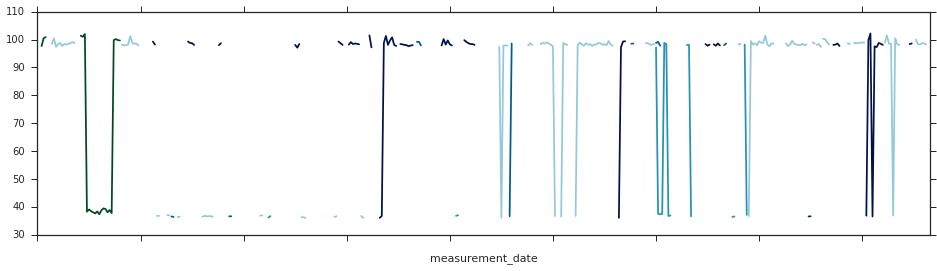

In [15]:
temp_table.plot(legend=False, figsize=(16,4));

We can convert the F temps to C using the Pandas `where` method and a simple conversion function. We will use the `unit_source_value` column to check the units of each temperature, and use that as the condition for converting to Celsius.

In [20]:
def to_celsius(F): 
    return (F - 32) / 1.8

measure_df['temp_C'] = measure_df.value_as_number.where(measure_df.unit_source_value=='C', 
                                 to_celsius)

In [23]:
temp_table = (measure_df.pivot_table(index='measurement_date', 
                                    columns='person_id', 
                                    values='temp_C', 
                                    aggfunc=max))

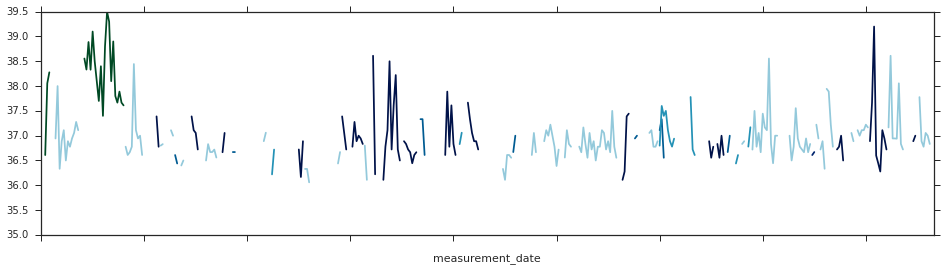

In [24]:
temp_table.plot(legend=False, figsize=(16,4));

## Querying the Kids cohort

As an example of creating more complex filters, let's look for kids who have an ID > 50000 or ID <= 100000.

In [25]:
from aou_workbench_client.cdr.model import Person

In [26]:
Person.columns

,Name,Type,Description
0,person_id,integer,A unique identifier for each person.
1,gender_concept_id,integer,A foreign key that refers to an identifier in the CONCEPT table for the unique gender of the person.
2,year_of_birth,integer,"The year of birth of the person. For data sources with date of birth, the year is extracted. For data sources where the year of birth is not available, the approximate year of birth is derived based on any age group categorization available."
3,month_of_birth,integer,"The month of birth of the person. For data sources that provide the precise date of birth, the month is extracted and stored in this field."
4,day_of_birth,integer,"The day of the month of birth of the person. For data sources that provide the precise date of birth, the day is extracted and stored in this field."
5,birth_datetime,timestamp,The date and time of birth of the person.
6,race_concept_id,integer,A foreign key that refers to an identifier in the CONCEPT table for the unique race of the person.
7,ethnicity_concept_id,integer,A foreign key that refers to the standard concept identifier in the Standardized Vocabularies for the ethnicity of the person.
8,location_id,integer,"A foreign key to the place of residency for the person in the location table, where the detailed address information is stored."
9,provider_id,integer,A foreign key to the primary care provider the person is seeing in the provider table.


In [27]:
person_id_filters = ResultFilters(all_of=[ResultFilters(column_filter=ColumnFilter(column_name="person_id", 
                                                           operator=Operator.GREATER_THAN_OR_EQUAL_TO,
                                                           value_number=50000)),
                                          ResultFilters(column_filter=ColumnFilter(column_name="person_id",
                                                           operator=Operator.LESS_THAN,
                                                           value_number=100000))])

Get their year of birth, gender, and race; order by year of birth then person ID.


In [28]:
person_table_query = TableQuery(table_name=PERSON_TABLE, 
                         columns=[Person.person_id,
                                  Person.year_of_birth,
                                  Person.gender_concept.concept_name,
                                  Person.race_concept.concept_name,
                                  Person.ethnicity_concept.concept_name],
                                filters=person_id_filters,
                         order_by=[Person.year_of_birth, Person.person_id])

person_request = MaterializeCohortRequest(cohort_name="Kids", 
                                   field_set=FieldSet(table_query=person_table_query), 
                                   page_size=100)

person_response = materialize_cohort(person_request, max_results=1000)

person_response_df = pd.DataFrame(list(person_response))

In [29]:
person_response_df.shape

(411, 5)

In [30]:
person_response_df.head()

,ethnicity_concept.concept_name,gender_concept.concept_name,person_id,race_concept.concept_name,year_of_birth
0,Not Hispanic or Latino,FEMALE,50005,White,1999
1,Not Hispanic or Latino,MALE,50044,White,1999
2,Not Hispanic or Latino,MALE,50068,Black or African American,1999
3,Not Hispanic or Latino,FEMALE,50148,Black or African American,1999
4,Not Hispanic or Latino,FEMALE,50190,White,1999


Get all the heart rate measurements corresponding to these individuals using `ResultFilter`s. They correspond to concept IDs of 44818701 for measurement type and 3027018 for measurement, respectively. We are also going to apply the `person_id` constraint here as well.

In [31]:
measurement_filters = ResultFilters(all_of=[ResultFilters(column_filter=ColumnFilter("measurement_type_concept_id", 
                                                                value_number=PHYSICAL_EXAMINATION_CONCEPT_TYPE)),
                                            ResultFilters(column_filter=ColumnFilter("measurement_concept_id", 
                                                                value_number=HEART_RATE_CONCEPT_ID)),
                                            ResultFilters(column_filter=ColumnFilter(column_name="person_id", 
                                                           operator=Operator.GREATER_THAN_OR_EQUAL_TO,
                                                           value_number=50000)),
                                            ResultFilters(column_filter=ColumnFilter(column_name="person_id",
                                                           operator=Operator.LESS_THAN,
                                                           value_number=100000))])

In [32]:
heart_rate_query = TableQuery(table_name=MEASUREMENT_TABLE, 
                              columns=[Measurement.person_id, Measurement.value_as_number],
                              filters=measurement_filters)

heart_rate_request = MaterializeCohortRequest(cohort_name ="Kids", 
                                               field_set=FieldSet(table_query=heart_rate_query))

heart_rate_response = materialize_cohort(heart_rate_request, max_results=5000)

heart_rate_df = pd.DataFrame(list(heart_rate_response))

Customize columns

In [33]:
heart_rate_df.columns = 'person_id', 'heart_rate'

In [34]:
heart_rate_df.head()

,person_id,heart_rate
0,50005,82.0
1,50005,95.0
2,50005,83.0
3,50005,111.0
4,50005,119.0


Pandas allows you to easily **merge** these two datasets, which have a one-to-many relational association. The `merge` method (or function) will by default merge on the columns with the same name, in this case, `person_id`

In [35]:
kids_merged = person_response_df.merge(heart_rate_df)

In [36]:
kids_merged.head()

,ethnicity_concept.concept_name,gender_concept.concept_name,person_id,race_concept.concept_name,year_of_birth,heart_rate
0,Not Hispanic or Latino,FEMALE,50005,White,1999,82.0
1,Not Hispanic or Latino,FEMALE,50005,White,1999,95.0
2,Not Hispanic or Latino,FEMALE,50005,White,1999,83.0
3,Not Hispanic or Latino,FEMALE,50005,White,1999,111.0
4,Not Hispanic or Latino,FEMALE,50005,White,1999,119.0


Notice that there are some bad heart rate values that need to be dropped:

In [37]:
kids_merged.heart_rate.min()

0.0

In [38]:
kids_merged.heart_rate.max()

1006.0

The `query` method can be used to truncate `heart_rate` to a reasonable range:

In [39]:
kids_merged = kids_merged.query('heart_rate>20 & heart_rate<200')

Pandas includes several high-level plotting methods. For example, we can see the histogram of all heart rates across the queried subset.

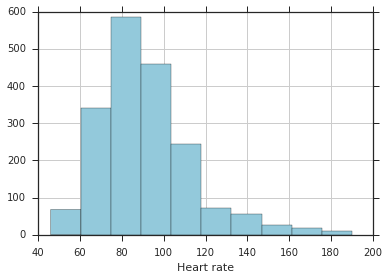

In [40]:
kids_merged.heart_rate.hist().set_xlabel('Heart rate');

Of course, we might want to break this down by individual, since each measurement is not independent. 

First, however, we will filter individuals with a small number of heart rate measurements.

In [41]:
kids_merged.groupby('person_id').size()

person_id
50005    24
50044    1 
50068    1 
50148    1 
50190    3 
50287    1 
50361    38
50439    1 
50568    1 
50919    4 
50975    2 
51052    17
51289    1 
51339    2 
51536    3 
51560    8 
51716    6 
51840    4 
51922    5 
51981    1 
52073    1 
52300    6 
52327    1 
52558    2 
52565    1 
52756    1 
53073    1 
53235    1 
53314    53
53572    1 
        .. 
95065    1 
95088    1 
95101    1 
95355    6 
95367    3 
95565    3 
95828    3 
96220    2 
96229    1 
96320    3 
96589    3 
96662    2 
97264    1 
97338    1 
97343    6 
97521    1 
97649    15
97942    18
98010    2 
98303    55
98431    2 
98493    2 
98588    27
99281    6 
99285    19
99333    11
99374    5 
99432    1 
99592    28
99787    1 
Length: 319, dtype: int64

In [42]:
lots_of_data = kids_merged.groupby('person_id').size() > 20
greater_than_20_ids = set(lots_of_data[lots_of_data].index)

The `seaborn` package provides a high-level API for generating faceted statistical plots. 

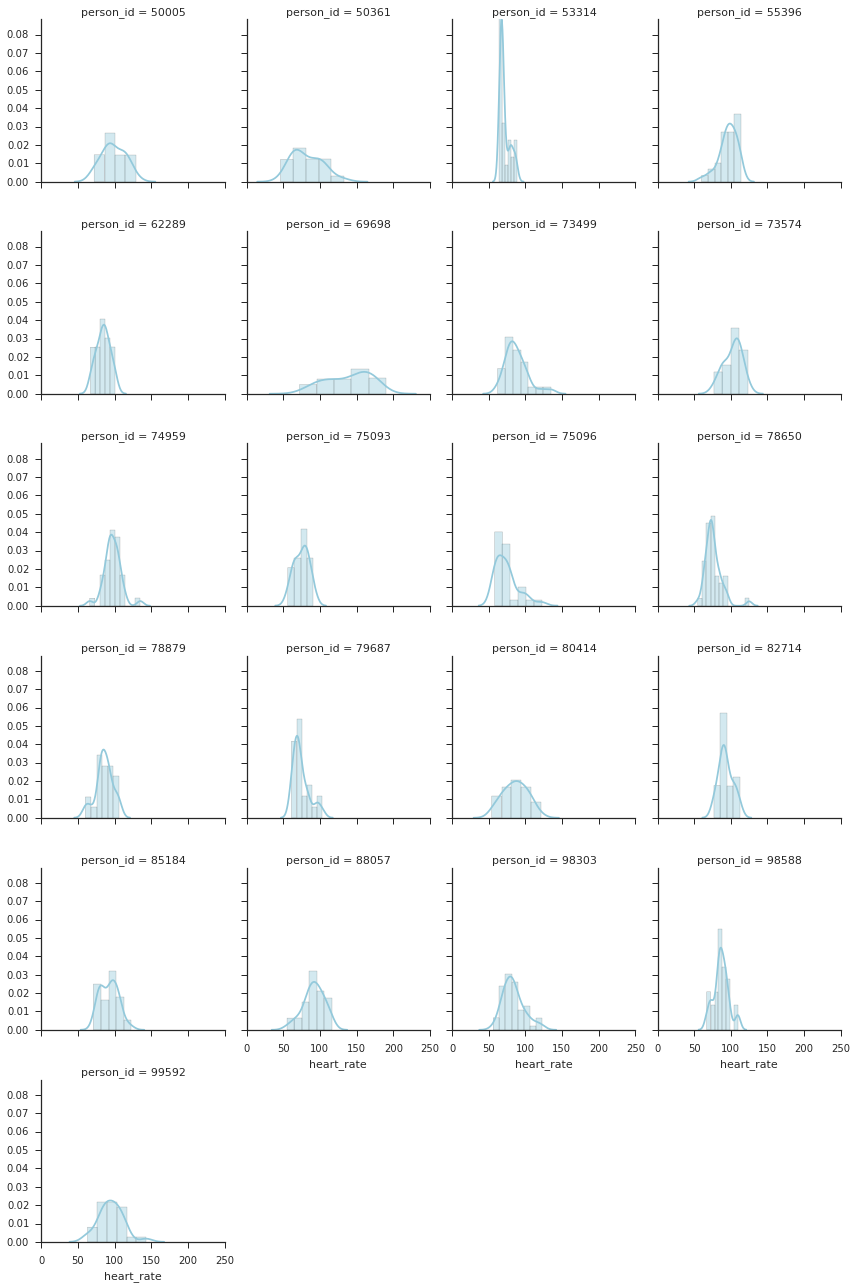

In [43]:
g = sns.FacetGrid(kids_merged[kids_merged.person_id.isin(greater_than_20_ids)], col='person_id', col_wrap=4)
g.map(sns.distplot, 'heart_rate');

We can run a simple statistical analysis on this data. For example, we can create a regression model that predicts mean heart rate from demographic information. For this, I will use PyMC3, which you can install from `pip` if it is not available:

    !pip install --user -U pymc3

In [44]:
import pymc3 as pm

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)


A few of the variables need to be recoded to numeric quantities. For simplicity, I will use binary predictors.

In [45]:
kids_merged['female'] = (kids_merged['gender_concept.concept_name']=='FEMALE').astype(int)
kids_merged['non_white'] = (kids_merged['race_concept.concept_name']=='White').astype(int)
kids_merged['hispanic'] = (kids_merged['ethnicity_concept.concept_name']=='Hispanic or Latino').astype(int)

A simple regression can be coded in one line of PyMC.

In [46]:
with pm.Model() as hr_regression:
    pm.GLM.from_formula('heart_rate ~ female + non_white + hispanic', data=kids_merged)

This is a Bayesian model, so MCMC can be used to estimate the parameters.

In [47]:
with hr_regression:
    samples = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, hispanic, non_white, female, Intercept]
100%|██████████| 3000/3000 [00:09<00:00, 326.06it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '19494' (I am process '20663')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jupyter-user/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.10--3.4.2-64/lock_dir


Results can be summarized in a table, or with graphical output.

In [48]:
pm.summary(samples)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,92.389082,1.063489,0.028370,90.281140,94.377790,1352.049563,0.999924
female,3.551112,0.995607,0.019372,1.651675,5.484316,2180.180681,0.999505
non_white,-4.296087,1.101479,0.029061,-6.458905,-2.233432,1583.351676,0.999819
hispanic,-3.995944,2.104381,0.043068,-7.909495,0.033607,2134.949754,0.999500
sd,21.725676,0.335977,0.006903,21.077589,22.378346,2445.192355,0.999697


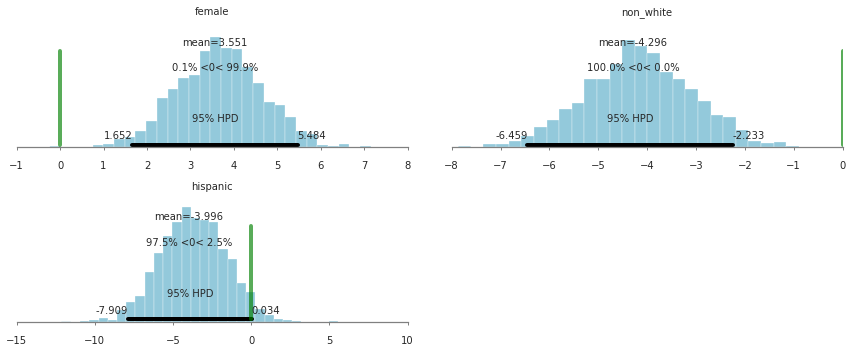

In [49]:
pm.plot_posterior(samples, varnames=['female', 'non_white', 'hispanic'], ref_val=0);